In [41]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

### chair의 이미지 해상도 통일하여 적용하기 Test

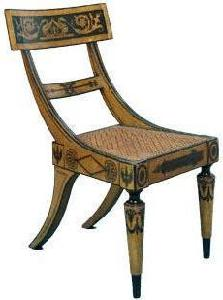

In [42]:
# Image
img = Image.open("../Data/chair/image_0001.jpg")
img

In [43]:
# 배열 확인 (해상도)
np.array(img).shape
# 223, 300


(300, 223, 3)

In [44]:
# Image
img = Image.open("../Data/chair/image_0002.jpg")
img
np.array(img).shape
# 200, 300

(300, 200, 3)

> Image의 해상도가 일정하지 않다    
> 전체 이미지 해상도의 평균으로 적용해보자

---
### chair 전체 이미지의 평균 해상도 구하기

In [45]:
import glob
widthRatio = []
heightRatio = []
for file in sorted(glob.glob("../Data/chair/*.jpg")):
    img = np.array(Image.open(file),dtype=np.int32)
    widthRatio.append(img.shape[1])
    heightRatio.append(img.shape[0])

print('chair의 너비 평균 해상도:',np.mean(widthRatio))
print('chair의 높이 평균 해상도:',np.mean(heightRatio))
print(len(widthRatio))
print(len(heightRatio))


chair의 너비 평균 해상도: 230.69354838709677
chair의 높이 평균 해상도: 296.98387096774195
62
62


> 너비: 231, 높이: 297로 정함

---
### chair의 이미지 해상도 변경 및 gray scale로 적용

In [46]:
# chair의 파일 개수: 62
# i: 변경한 이미지의 filename
i = 0
for file in sorted(glob.glob("../Data/chair/*.jpg")):
    img = Image.open(file)
    # sampling: 해상도 확장 시 비어있는 부분을 채우는 방식
    imgResize = img.resize((231,297),Image.Resampling.LANCZOS)
    imgResize = imgResize.convert('L') # Gray Scale, 투명도가 있는 경우 LA
    imgResize.save("../Data/chairNew/image_%04d.jpg"%i, 'JPEG')
    i += 1
    if i >= 62:
        break

---
### chair image를 numpy로 변경

In [47]:
number_of_data = 62 # 데이터 수
img_width_size = 231
img_height_size = 297
# python list []: 변경 가능; np.array: 변경 불가

chairData = np.zeros(number_of_data * img_width_size * img_height_size, dtype=np.int32).reshape(number_of_data,img_height_size,img_width_size)
print(chairData.shape)
# chairData

(62, 297, 231)


In [48]:
i = 0
for file in sorted(glob.glob("../Data/chairNew/*.jpg")):
    img = np.array(Image.open(file),dtype=np.int32)
    chairData[i,:,:] = img
    i+=1
    if i >= 62:
        break

len(chairData)

62

In [49]:
chairData.shape

(62, 297, 231)

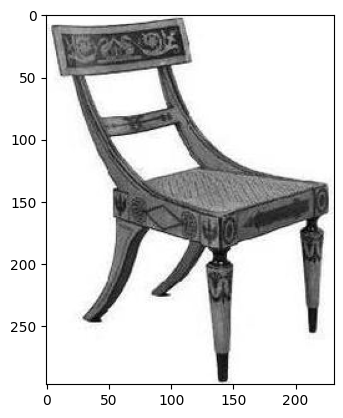

In [50]:
import matplotlib.pyplot as plt
plt.imshow(chairData[0],cmap='gray')
plt.show()

---
### labtop image

In [51]:
i = 0
for file in sorted(glob.glob("./Data/laptop/*.jpg")):
    img = Image.open(file)
    imgResize = img.resize((231,297),Image.Resampling.LANCZOS)
    imgResize = imgResize.convert('L')
    imgResize.save("./Data/laptopNew/image_%04d.jpg"%i, 'JPEG')
    i += 1
    if i >= 81:
        break

In [52]:
number_of_laptop = 81
laptopData = np.zeros(number_of_laptop * img_width_size * img_height_size, dtype=np.int32).reshape(number_of_laptop,img_height_size,img_width_size)
i = 0
for file in sorted(glob.glob("./Data/laptopNew/*.jpg")):
    img = np.array(Image.open(file),dtype=np.int32)
    laptopData[i,:,:] = img
    i+=1
    if i >= 81:
        break

len(laptopData)

81

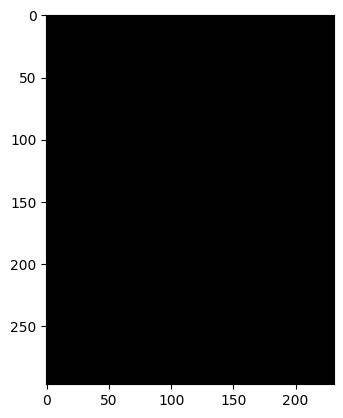

In [53]:
plt.imshow(laptopData[0],cmap='gray')
plt.show()

---
### numpy data를 train data로 합치기

In [54]:
train = np.concatenate([chairData,laptopData])
train.shape

(143, 297, 231)

### target data

In [55]:
target = np.concatenate([np.zeros(62), np.ones(81)])
print(target)
print(len(target))


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
143


In [56]:
# data 준비
from sklearn.model_selection import train_test_split
train_scaled = train.reshape(-1, 297, 231, 1) / 255.0 # gray: channel 1
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, target, test_size=0.2, random_state=42)

In [57]:
print(train_scaled.shape)
print(val_scaled.shape)
print(train_target.shape)
print(val_target.shape)

(114, 297, 231, 1)
(29, 297, 231, 1)
(114,)
(29,)


In [58]:
# model
model = keras.Sequential()
# 합성곱 층
model.add(keras.layers.Conv2D(32, kernel_size = 3, activation = 'relu', padding='same', input_shape = (297,231,1)))
# 풀링 층
# model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.AveragePooling2D(2))
model.add(keras.layers.Conv2D(64, kernel_size = 3, activation='relu', padding='same'))
# model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.AveragePooling2D(2))
# Dense 층
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
# model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(2,activation='sigmoid'))

In [59]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 297, 231, 32)      320       
                                                                 
 average_pooling2d_4 (Averag  (None, 148, 115, 32)     0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 148, 115, 64)      18496     
                                                                 
 average_pooling2d_5 (Averag  (None, 74, 57, 64)       0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 269952)            0         
                                                                 
 dense_4 (Dense)             (None, 100)              

In [60]:
print(train_scaled.shape)
print(train_target.shape)
print(val_scaled.shape)
print(val_target.shape)

(114, 297, 231, 1)
(114,)
(29, 297, 231, 1)
(29,)


In [61]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint("./Data/best_cnn_chair_laptop.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=30, validation_data=[val_scaled,val_target],callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/30
4/4 [==============================] - 3s 572ms/step - loss: 0.5427 - accuracy: 0.5000 - val_loss: 0.3899 - val_accuracy: 1.0000
Epoch 2/30
4/4 [==============================] - 2s 452ms/step - loss: 0.3436 - accuracy: 1.0000 - val_loss: 0.2569 - val_accuracy: 1.0000
Epoch 3/30
4/4 [==============================] - 2s 465ms/step - loss: 0.1737 - accuracy: 1.0000 - val_loss: 0.0470 - val_accuracy: 1.0000
Epoch 4/30
4/4 [==============================] - 2s 419ms/step - loss: 0.0229 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 5/30
4/4 [==============================] - 2s 428ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 5.0752e-05 - val_accuracy: 1.0000
Epoch 6/30
4/4 [==============================] - 2s 438ms/step - loss: 2.8123e-05 - accuracy: 1.0000 - val_loss: 2.4500e-06 - val_accuracy: 1.0000
Epoch 7/30
4/4 [==============================] - 3s 810ms/step - loss: 1.3845e-06 - accuracy: 1.0000 - val_loss: 2.0964e-07 - val_accuracy: 1.0000


In [62]:
best_model = keras.models.load_model("./Data/best_cnn_chair_laptop.h5")

In [63]:
best_model.evaluate(train_scaled,train_target)

4/4 [==============================] - 1s 107ms/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]

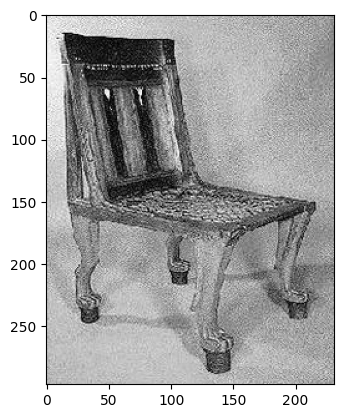

1/1 [==============================] - 0s 63ms/step
chair


In [64]:
dataName = ['chair','laptop']
plt.imshow(val_scaled[28].reshape(297,231),cmap='gray')
plt.show()
preds = best_model.predict(val_scaled[28:29])
print(dataName[np.argmax(preds)])

In [65]:
val_scaled[28].reshape(297,231)

array([[0.85490196, 0.90980392, 0.89411765, ..., 0.58823529, 0.58823529,
        0.63921569],
       [0.94901961, 0.88627451, 0.87843137, ..., 0.58823529, 0.49019608,
        0.69803922],
       [1.        , 0.83137255, 0.85882353, ..., 0.55686275, 0.52156863,
        0.52156863],
       ...,
       [0.8       , 0.74117647, 0.77647059, ..., 0.65490196, 0.61176471,
        0.56078431],
       [0.81960784, 0.75294118, 0.68627451, ..., 0.57647059, 0.61176471,
        0.70196078],
       [0.76078431, 0.68627451, 0.63921569, ..., 0.59215686, 0.6745098 ,
        0.65882353]])

In [66]:
laptop_test = Image.open("./Data/laptop_test.jpeg")
# 흑백 반전: 255-image
laptop_test = 255-(np.array(laptop_test,dtype=np.int32).reshape(1,297,231,1)/255)

FileNotFoundError: [Errno 2] No such file or directory: './Data/laptop_test.jpeg'

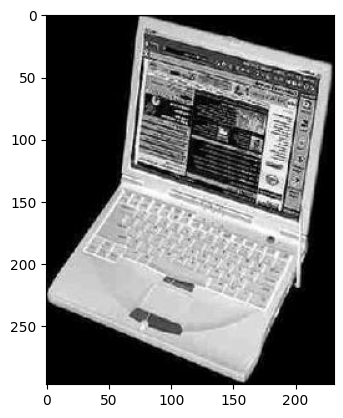

1/1 [==============================] - 0s 18ms/step
1
laptop


In [ ]:
plt.imshow(laptop_test[0],cmap='gray')
plt.show()
preds = best_model.predict(laptop_test)
print(np.argmax(preds))
print(dataName[np.argmax(preds)])

In [ ]:
chair_test = Image.open("./Data/chair_test.jpeg")
chair_test = chair_test.resize((231,297),Image.Resampling.LANCZOS)
chair_test = chair_test.convert('L')
# 흑백 반전: 255-image
chair_test = 255-(np.array(chair_test,dtype=np.int32).reshape(1,297,231,1)/255)

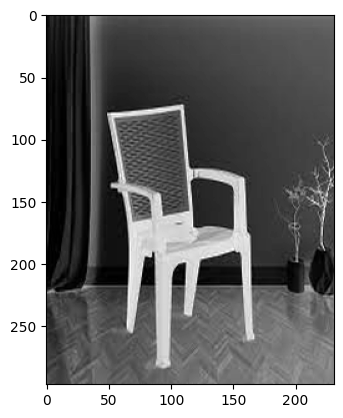

1/1 [==============================] - 0s 18ms/step
1
laptop


In [ ]:
plt.imshow(chair_test[0],cmap='gray')
plt.show()
preds = best_model.predict(chair_test)
print(np.argmax(preds))
print(dataName[np.argmax(preds)])

In [ ]:
chair_test2 = Image.open("./Data/chair_test2.jpeg")
chair_test2 = chair_test2.resize((231,297),Image.Resampling.LANCZOS)
chair_test2 = chair_test2.convert('L')
# 흑백 반전: 255-image
chair_test2 = 255-(np.array(chair_test2,dtype=np.int32).reshape(1,297,231,1)/255)

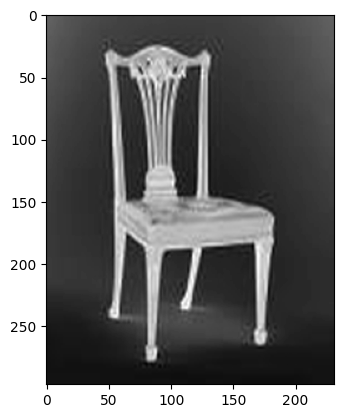

1/1 [==============================] - 0s 21ms/step
1
laptop


In [ ]:
plt.imshow(chair_test2[0],cmap='gray')
plt.show()
preds = best_model.predict(chair_test2)
print(np.argmax(preds))
print(dataName[np.argmax(preds)])